# Tensorflow Test
This is one of my first experiences with TF, I wish to follow the tutorials:
https://www.tensorflow.org/datasets/overview

## Imports

In [5]:
import torch
print(torch. __version__)

1.10.1+cu102


In [31]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

## Load MNIST Data

In [32]:
ds = tfds.load('mnist', split='train', shuffle_files=True)
assert isinstance(ds, tf.data.Dataset)
print(ds)
# The dataset is cached, and subsequent runs will be much faster

<_OptionsDataset shapes: {image: (28, 28, 1), label: ()}, types: {image: tf.uint8, label: tf.int64}>


## Find available Datasets

In [33]:
tfds.list_builders()

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'arc',
 'asset',
 'assin2',
 'bair_robot_pushing_small',
 'bccd',
 'beans',
 'bee_dataset',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'blimp',
 'booksum',
 'bool_q',
 'c4',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cardiotox',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'cfq',
 'cherry_blossoms',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar10_1',
 'cifar10_corrupted',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'clic',
 'clinc_oos',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coco_captions',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'common_voice',
 'coqa',
 'cos_e',
 'cosmos_qa',
 'covid19',
 'covid19sum',
 'crema_d',
 'cs_restaurants',
 'curated_breast_imaging_ddsm',
 'cycle_gan',
 'd4rl_adroit_door',
 'd4rl_adr

## Split Data

In [34]:
ds_train = tfds.load('mnist', split='train', as_supervised=True)
ds_test = tfds.load('mnist', split='test', as_supervised=True)
print("Training length of ", len(ds_train))
print("Testing length of ", len(ds_test))

for image, label in ds_train:  # example is (image, label)
  print(image.shape, label)
  print("Range: ", image.numpy().min(), image.numpy().max())
  break

# Clean version of the loading done above:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

Training length of  60000
Testing length of  10000
(28, 28, 1) tf.Tensor(4, shape=(), dtype=int64)
Range:  0 255


## Process Data Pipeline

In [35]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE) # Map images from uint8 to tf.float32 (i.e [0,255] --> [0,1])
ds_train = ds_train.cache() # Cache before shuffling for improved performance
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples) # Shuffle data. Since the buffer size is the entire dataset, true randomness is achieved, but also with high memory usage.
ds_train = ds_train.batch(128) # Batch elements
ds_train = ds_train.prefetch(tf.data.AUTOTUNE) # The prefetch allows the model to be fetching the next preprocessed batch while the current training step is occuring

## Evaluation Pipeline

In [36]:
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

## Model Creation

In [52]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10)
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(), tf.keras.metrics.CategoricalHinge()], # Hinge loss is a loss function for max-margin classifiers. That explains why it increases here, but loss and accuracy still converge to good values.
)

## Train Model

In [53]:
model.fit(
    ds_train,
    epochs=6,
    validation_data=ds_test,
)

Epoch 1/6
469/469 [==============================] - 1s 1ms/step - loss: 0.3627 - sparse_categorical_accuracy: 0.8999 - categorical_hinge: 62.4476 - val_loss: 0.2000 - val_sparse_categorical_accuracy: 0.9435 - val_categorical_hinge: 84.2248
Epoch 2/6
469/469 [==============================] - 1s 1ms/step - loss: 0.1687 - sparse_categorical_accuracy: 0.9522 - categorical_hinge: 92.4897 - val_loss: 0.1351 - val_sparse_categorical_accuracy: 0.9593 - val_categorical_hinge: 101.5009
Epoch 3/6
469/469 [==============================] - 1s 1ms/step - loss: 0.1201 - sparse_categorical_accuracy: 0.9651 - categorical_hinge: 108.2102 - val_loss: 0.1159 - val_sparse_categorical_accuracy: 0.9641 - val_categorical_hinge: 118.1811
Epoch 4/6
469/469 [==============================] - 1s 1ms/step - loss: 0.0926 - sparse_categorical_accuracy: 0.9729 - categorical_hinge: 126.6123 - val_loss: 0.0948 - val_sparse_categorical_accuracy: 0.9723 - val_categorical_hinge: 136.5352
Epoch 5/6
469/469 [============

## Anecdotal Testing

Image label:  2


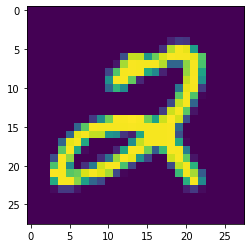

Image label:  0


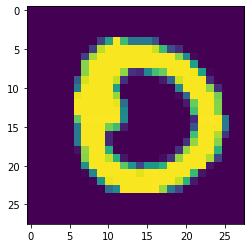

Image label:  4


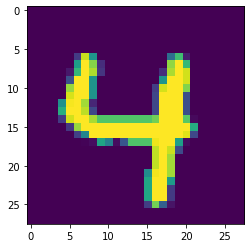

Image label:  8


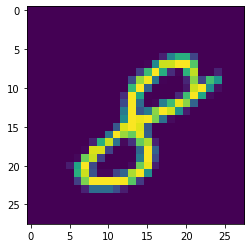

Image label:  7


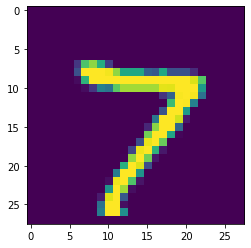

Image label:  6


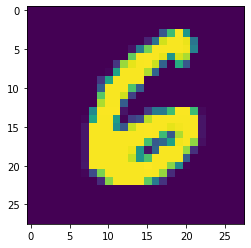

Image label:  0


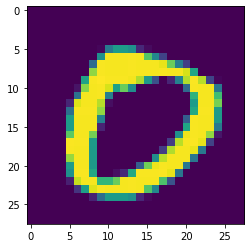

Image label:  6


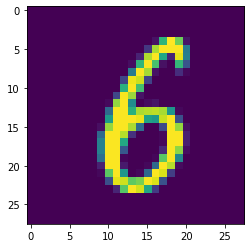

Image label:  3


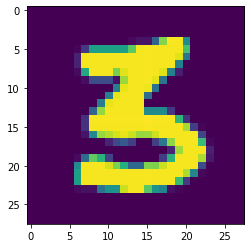

Image label:  1


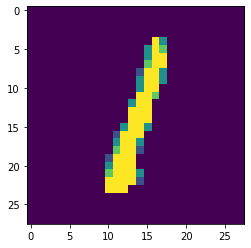

Image label:  8


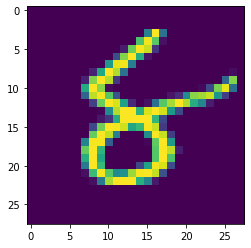

In [62]:
ds_test_anec = tfds.load('mnist', split='test', as_supervised=True)
ds_test_anec = ds_test_anec.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)

num_show = 10
on_num = 0
for image, label in ds_test_anec:  # example is (image, label)
    print("Image label: ", label.numpy())
    imgplot = plt.imshow(image)
    plt.show()
    on_num+=1
    if on_num > num_show:
        break

